The purpose of this note book is to quickly impliment a version of the xylem imparment, growth and death described in section 2.6 of [A.Pahchalis et al 2023](https://pubmed.ncbi.nlm.nih.gov/37962234/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

# Introduction
Section 2.6 of [A.Pahchalis et al 2023](https://pubmed.ncbi.nlm.nih.gov/37962234/) describes a conductance model that acounts for not only xylem damage but the growth and death of xylem. In breaf it models the impared conductance of a set of xylem of the same age as the minimum conductance achived over the xylems life span. Growth and death is modeld by tracking the number of xylem of as a function of age, adding newly grown xylem with age zero while removing xylem across ages. The conductance of the whole system can be calculated by intergrating the multiplication of the conductance and number of xylem over their age .

# Conductance as a function of age

As described previously, the conductance of a set of xylem of the same age is equal to the minimum conductance during their lifetime. The minimum conductance is that given by the xylem vunrability curve, $k(\psi)$, at the minimum water potential reached during the xylems life time, $\psi_{min}(\alpha, t) = MIN(\psi(t'))$ for $t' \in [t - \alpha, t]$.

$$
k(\alpha, t) = k(\psi_{min}(\alpha, t))
$$

In [2]:
def update_xylem_conductances(xylem_k, current_k):

    # Age the xylem by shifing them one index in historic_k
    xylem_k[1:] = xylem_k[:-1]

    # Set the conductance of the new xylem to the current conductance
    xylem_k[0] = current_k
    
    # Reduce any xylem conductance over the current conductance to the current conductance
    xylem_k = np.clip(xylem_k, 0, current_k)

    return xylem_k

To test this we create a fake set of conductance values over some time period and then iterativly calculate the xylem conductance as a function of age over this time period.

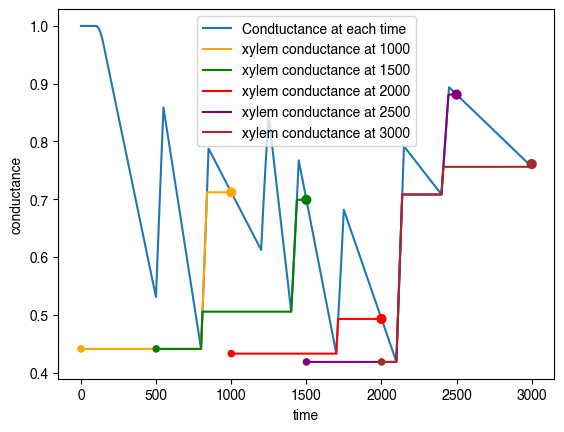

In [3]:
# Number of xylem ages to record conductance and later population over.
num_ages = 1000
ages = np.asarray([i for i in range(num_ages)])
# Array to contain historic conductances.
xylem_k = np.zeros(num_ages)

# Driving data
time_steps = 3001
time = np.linspace(0, time_steps, time_steps)
k_over_t = np.ones(time_steps)

# Create fake conductance with drops in data
k_drops = [[ 100,  500, 1.0, 0.5],
           [ 500,  800, 0.9, 0.4],
           [ 800, 1200, 0.8, 0.6],
           [1200, 1400, 0.9, 0.45],
           [1400, 1700, 0.8, 0.4],
           [1700, 2100, 0.7, 0.4],
           [2100, 2400, 0.8, 0.7],
           [2400, 3000, 0.9, 0.75]
          ]
for drop in k_drops:
    k_over_t[drop[0]:drop[1]] = np.linspace(drop[2], drop[3], drop[1] - drop[0])

# smooth the fake data
window = 50
k_over_t = np.convolve(k_over_t, np.ones(window)/window)[:time_steps]
k_over_t[:window] = 1.0

# Step the model through time and record the results at multiple time steps
snapshot_times = [1000, 1500, 2000, 2500, 3000]
k_over_t_snapshots = np.zeros((len(snapshot_times),num_ages))

current_snapshot_id = 0
for i in range(time_steps):
    xylem_k = update_xylem_conductances(xylem_k, k_over_t[i])

    if(snapshot_times[current_snapshot_id] == i):
        k_over_t_snapshots[current_snapshot_id,:] = xylem_k[:]

        current_snapshot_id += 1

colours = ["orange", "green", "red", "purple", "brown"]

plt.plot(time, k_over_t, label = "Condtuctance at each time", zorder = 0)

for i in range(len(snapshot_times)):
    plt.plot(snapshot_times[i] - ages, k_over_t_snapshots[i,:],
             c = colours[i], label = "xylem conductance at {}".format(snapshot_times[i]), zorder = 1)
    plt.scatter([snapshot_times[i], snapshot_times[i] - ages[-1]], [k_over_t_snapshots[i,0], k_over_t_snapshots[i,-1]],
                s = [40,20], c = colours[i], zorder = 2)

plt.legend()
plt.xlabel("time")
plt.ylabel("conductance")
plt.show()

# Xylem population as a funcction of age

In adition to the conductance we need to trak the number of xylem as a function of age. We define the population as the function $p(\alpha, t)$, where $\alpha$ is the age of the zylem and $t$ is the current time (note, in the paper this is writen as $p_\alpha(t)$). How the population changes as a function of time is described by the following partial differential;

$$
\frac{\partial}{\partial t}p(\alpha, t) = - \frac{\partial}{\partial \alpha} p(\alpha,t) - \mu_x(\alpha,t)p(\alpha,t)
$$

Within this equation the first component, the partial derivative of $p(\alpha,t)$ with respect to age $\alpha$, ages the xylem moving them to higher $\alpha$. The second component makes use of the wood turnover rate $\mu(\alpha,t)$ to kill off or remove xylem from the system. The shape of the turnover rate $\mu(\alpha,t)$ with respect to age, $\alpha$, can be used to preferentialy remove older xylem. Within this work we make $\mu(\alpha,t)$ constant with age, $\alpha$.

The growth of new xylem is modeld by setting the value of the xylem population with age zero to the rate at which xylem are creted, $\lambda(t)$, 

$$
\mu(0,t) = \lambda(t)
$$

In [4]:
def update_xylem_population(xylem_pop, growth_rate, death_rate, time_step):
    
    # Age the xylem by shifing them one index in historic_k
    xylem_pop[1:] = xylem_pop[:-1]

    # Remove dead xylem
    xylem_pop = xylem_pop * ( 1 - death_rate * time_step)

    # Add new xylem
    xylem_pop[0] = growth_rate * time_step

    return xylem_pop

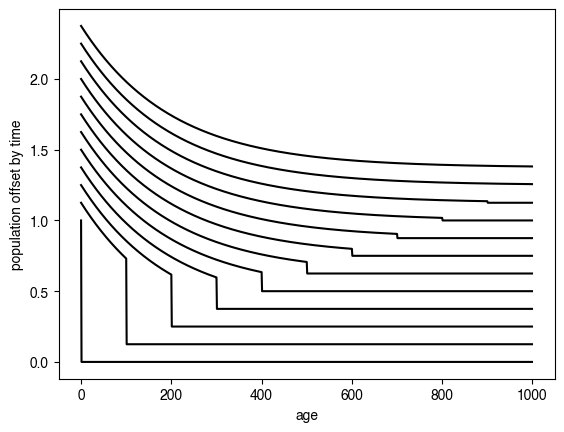

In [27]:
# Create array to hold xylem population
xylem_pop = np.zeros(num_ages)

# Set growth and death rates
growth_rate = 1
death_rate = 0.005

# Setup record of xylem population snapshots in time
num_snapshots = 12
snapshot_times = [i*100 for i in range(num_snapshots + 1)]
xylem_pop_snapshots = np.zeros((len(snapshot_times),num_ages))

# Time data
time_step = 1.
time_steps = snapshot_times[-1] + 1
time = np.linspace(0, time_steps, time_steps)

current_snapshot_id = 0
for i in range(time_steps):
    xylem_pop = update_xylem_population(xylem_pop, growth_rate, death_rate, time_step)

    if(snapshot_times[current_snapshot_id] == i):
        xylem_pop_snapshots[current_snapshot_id,:] = xylem_pop[:]
    
        current_snapshot_id += 1

for i in range(num_snapshots):
    #plt.plot(ages, np.ones(num_ages) * snapshot_times[i], c = 'grey')
    plt.plot(ages, xylem_pop_snapshots[i,:] + snapshot_times[i]/800, c = 'black')

plt.xlabel("age")
plt.ylabel("population offset by time")
plt.show()

We can see from the plot above that it takes time for the population distribution over age to reach a static shape between timesteps. It is worth noting that the exponential deccay occurs due to the turnpver rate being constant with age. At the start we can see that there are only xylem with age zero. As time progresses these first xylem age, moving the step in the plot to higher ages. From the shape of the final population age distribution it is clear that as age increses the number of serviving xylem drops due to th sapwood turnover rate removing a fraction each timestep.

It is important to note from the graph above that it takes a number of steps for the xylem age distribution to reach a steady state, as such one must let this happen prior to applying the model to data. This is also the point at which the total number of xylem in the system becomes constant.

# Calculating conductance

The conductance at a given point in time is given by the intergration with respect to age of the product of the xylem conductance and populations,

$$
k(t) = \int_0^\infty k(\psi_{min}(\alpha, t)) p(\alpha, t) d\alpha
$$

In [28]:
def conductance(xylem_k, xylem_pop):
    return np.sum(xylem_k * xylem_pop)

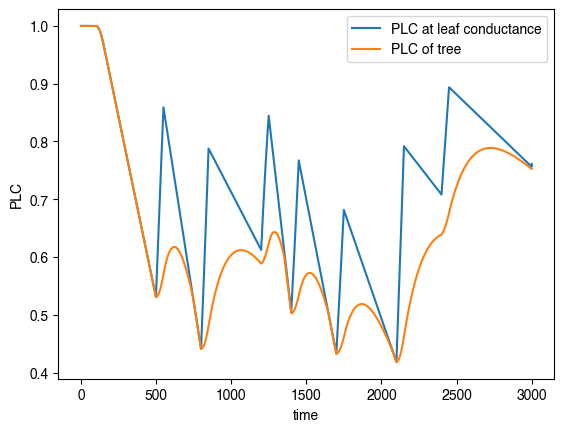

In [43]:
# Number of xylem ages to record conductance and later population over.
num_ages = 1000
ages = np.asarray([i for i in range(num_ages)])
# Array to contain historic conductances.
xylem_k = np.ones(num_ages)

# Driving data
time_steps = 3001
time = np.linspace(0, time_steps, time_steps)
k_leaf_over_t = np.ones(time_steps)

# Create fake conductance with drops in data
k_drops = [[ 100,  500, 1.0, 0.5],
           [ 500,  800, 0.9, 0.4],
           [ 800, 1200, 0.8, 0.6],
           [1200, 1400, 0.9, 0.45],
           [1400, 1700, 0.8, 0.4],
           [1700, 2100, 0.7, 0.4],
           [2100, 2400, 0.8, 0.7],
           [2400, 3000, 0.9, 0.75]
          ]
for drop in k_drops:
    k_leaf_over_t[drop[0]:drop[1]] = np.linspace(drop[2], drop[3], drop[1] - drop[0])

# smooth the fake data
window = 50
k_leaf_over_t = np.convolve(k_leaf_over_t, np.ones(window)/window)[:time_steps]
k_leaf_over_t[:window] = 1.0

# -- Calcualte the conductance --

# full tree conductance over time
tree_k = np.zeros(time_steps)
tree_PLC = np.zeros(time_steps)

current_snapshot_id = 0

for i in range(time_steps):

    # Update the xylem conductance and population logs
    xylem_k = update_xylem_conductances(xylem_k, k_over_t[i])
    xylem_pop = update_xylem_population(xylem_pop, growth_rate, death_rate, time_step)

    # Calculate the conductance
    tree_k[i] = conductance(xylem_k, xylem_pop)

    # Calculate PLC by dividing by the xylem population at that time.
    tree_PLC[i] = tree_k[i] / np.sum(xylem_pop)

# -- Plot the results --
plt.plot(time, k_leaf_over_t, label = "PLC at leaf conductance")
plt.plot(time, tree_PLC, label = "PLC of tree")


plt.legend()
plt.xlabel("time")
plt.ylabel("PLC")
plt.show()